In [3]:
# declaration

using Graphs
using Bloqade
using Random
using GenericTensorNetworks
using Optim
using KrylovKit
using SparseArrays

using PythonCall

plt = pyimport("matplotlib.pyplot");

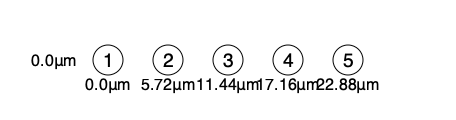

In [24]:
nsites = 5
atoms = generate_sites(ChainLattice(), nsites, scale = 5.72)

In [26]:
Ω = 2π * 4 # Rabi
Δ_step = 30 # Detuning increment
Δ = LinRange(-2π * 10, 2π * 10, Δ_step); # Detuning

In [27]:
density_g = zeros(Δ_step, nsites)

for ii in 1:Δ_step
    h_ii = rydberg_h(atoms; Δ=Δ[ii], Ω) # create the Rydberg Hamiltonian
    h_m = mat(h_ii) # convert the Hamiltonian into a matrix
    vals, vecs, info = KrylovKit.eigsolve(h_m,  1, :SR) # find the ground state eigenvalue and eigenvector
    g_state = ArrayReg(vecs[1]) # creates the initial state with all atoms in ``| 0 \rangle`` state

    for jj in 1:nsites
        density_g[ii, jj] = rydberg_density(g_state, jj) # measure the density of Rydberg excitations on each site
    end
end

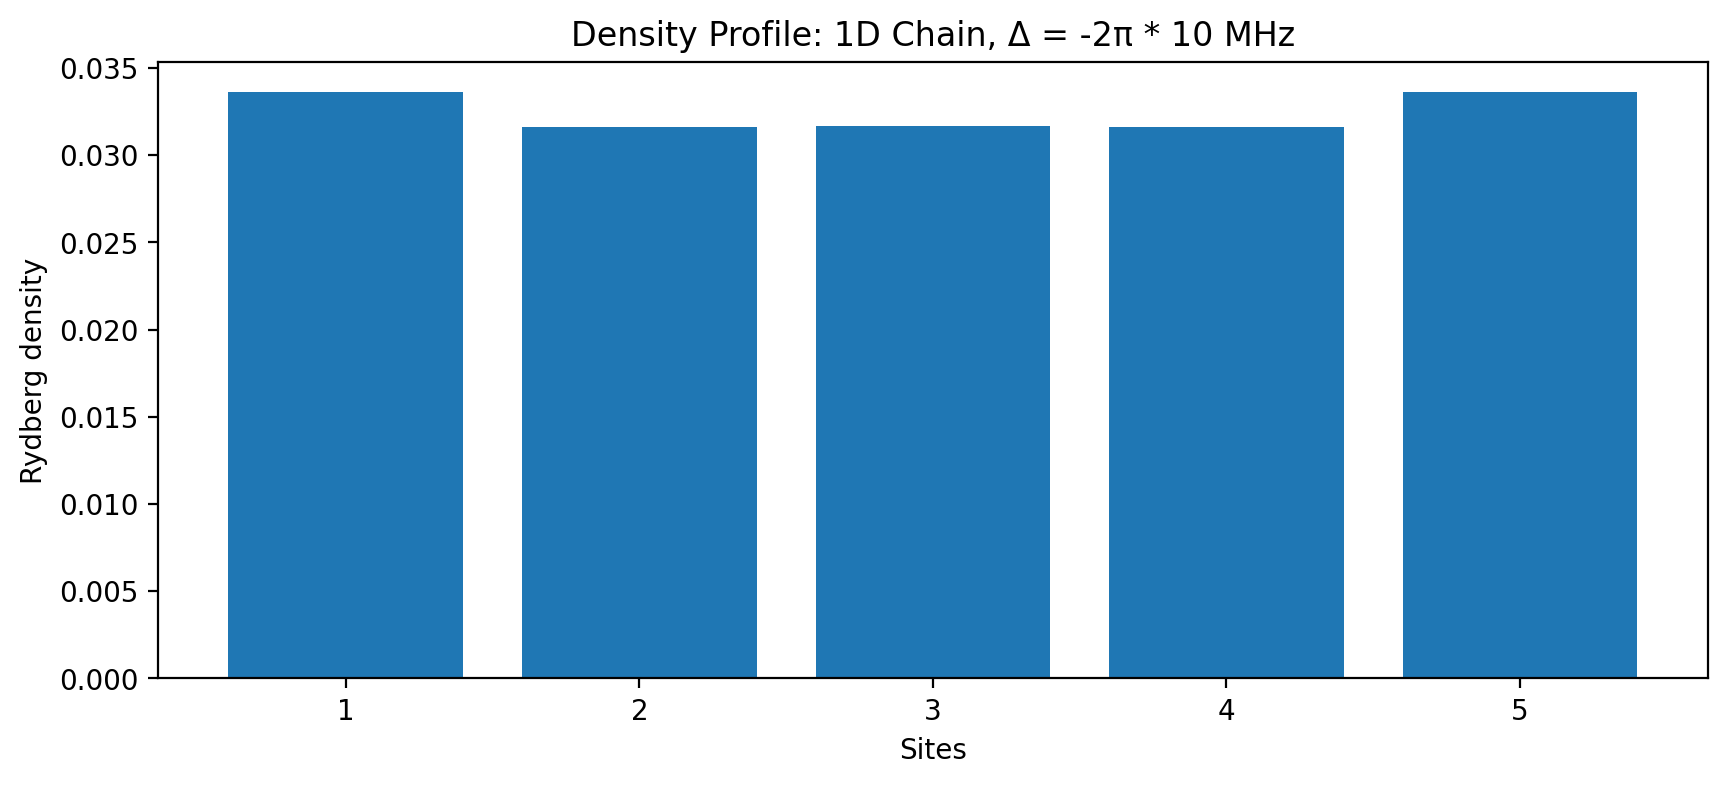

In [28]:
fig, ax = plt.subplots(figsize = (10, 4))
ax.bar(1:nsites, density_g[1, :])
ax.set_xticks(1:nsites)
ax.set_xlabel("Sites")
ax.set_ylabel("Rydberg density")
ax.set_title("Density Profile: 1D Chain, Δ = -2π * 10 MHz")
fig

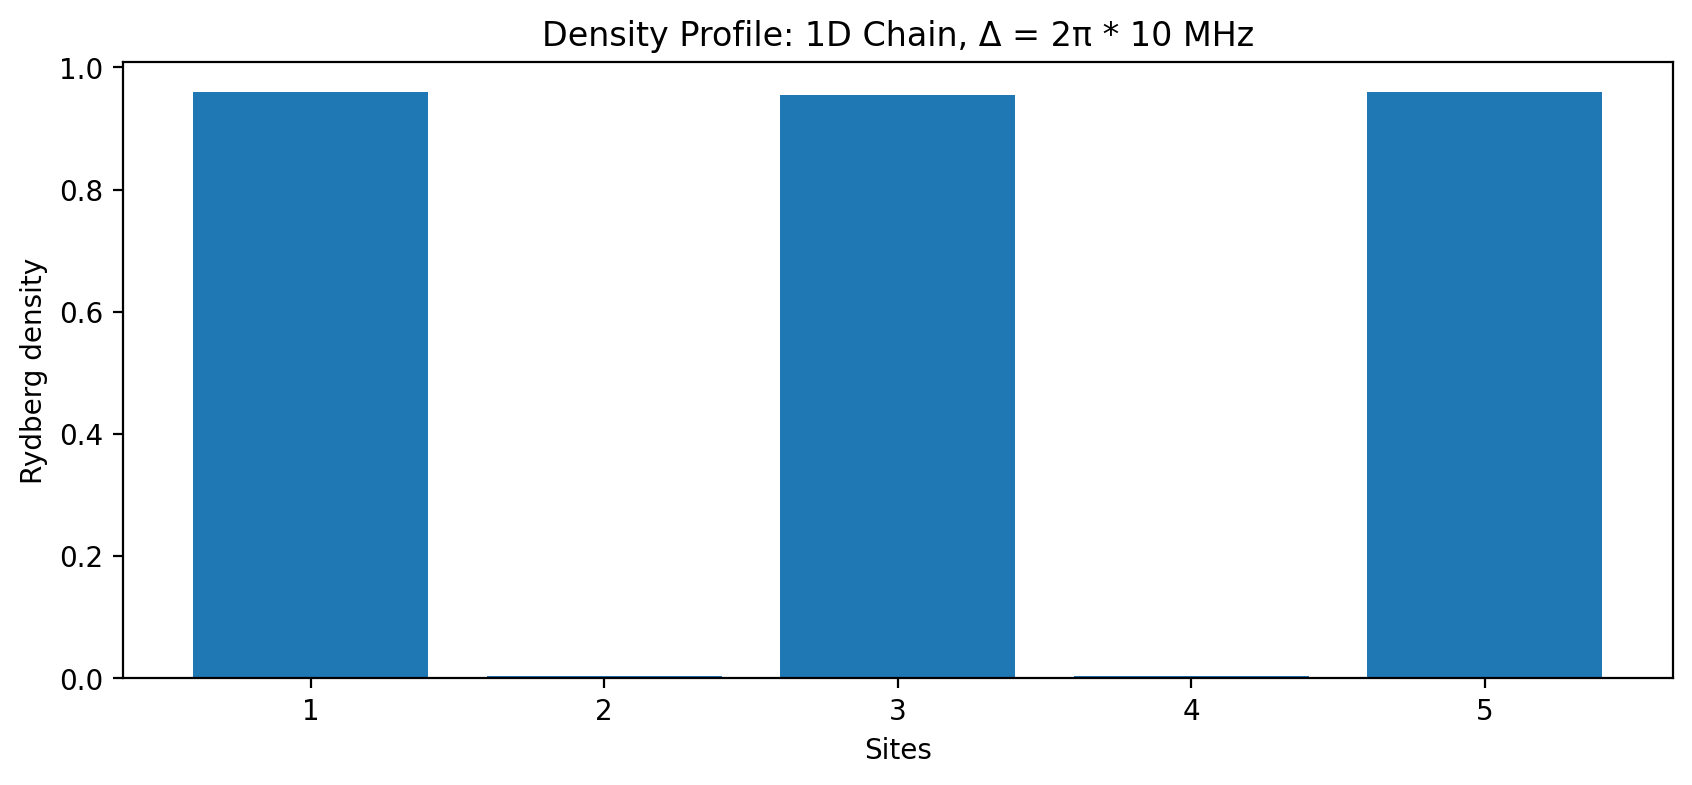

In [29]:
fig, ax = plt.subplots(figsize = (10, 4))
ax.bar(1:nsites, density_g[30, :])
ax.set_xticks(1:nsites)
ax.set_xlabel("Sites")
ax.set_ylabel("Rydberg density")
ax.set_title("Density Profile: 1D Chain, Δ = 2π * 10 MHz")
fig

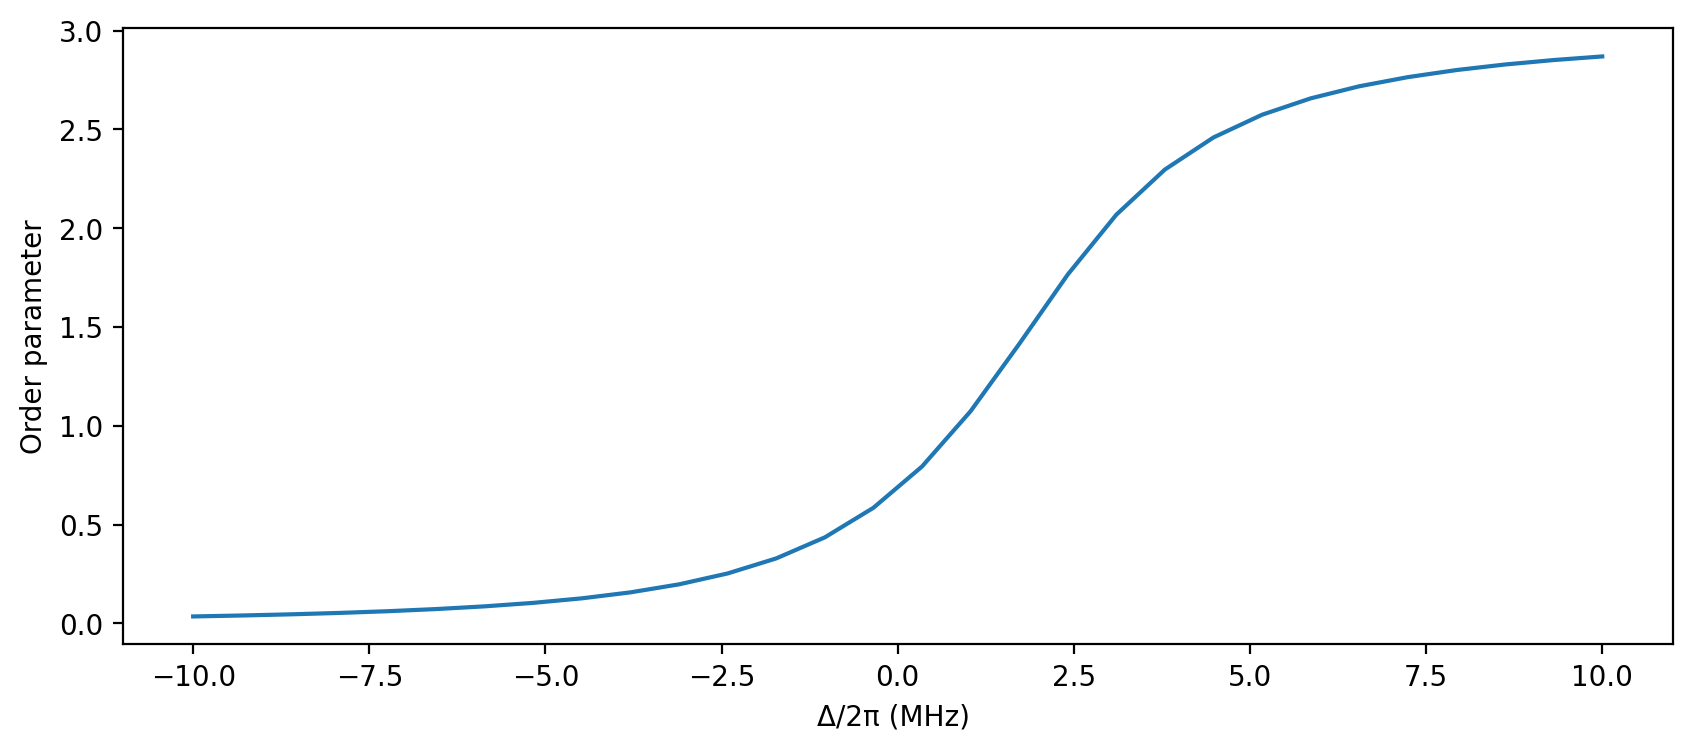

In [30]:
order_para = map(1: Δ_step) do ii
    sum(density_g[ii, 1:2:nsites]) - sum(density_g[ii, 2:2:nsites])
end

fig, ax = plt.subplots(figsize = (10,4))
ax.plot(Δ/2π, order_para)
ax.set_xlabel("Δ/2π (MHz) ")
ax.set_ylabel("Order parameter")
fig

In [31]:
# Preparing ordered state

total_time = 3.0;
Ω_max = 2π * 4;
Ω = piecewise_linear(clocks = [0.0, 0.1, 2.1, 2.2, total_time], values = [0.0, Ω_max, Ω_max, 0, 0]);

In [32]:
U1 = -2π * 10;
U2 = 2π * 10;
Δ = piecewise_linear(clocks = [0.0, 0.6, 2.1, total_time], values = [U1, U1, U2, U2]);

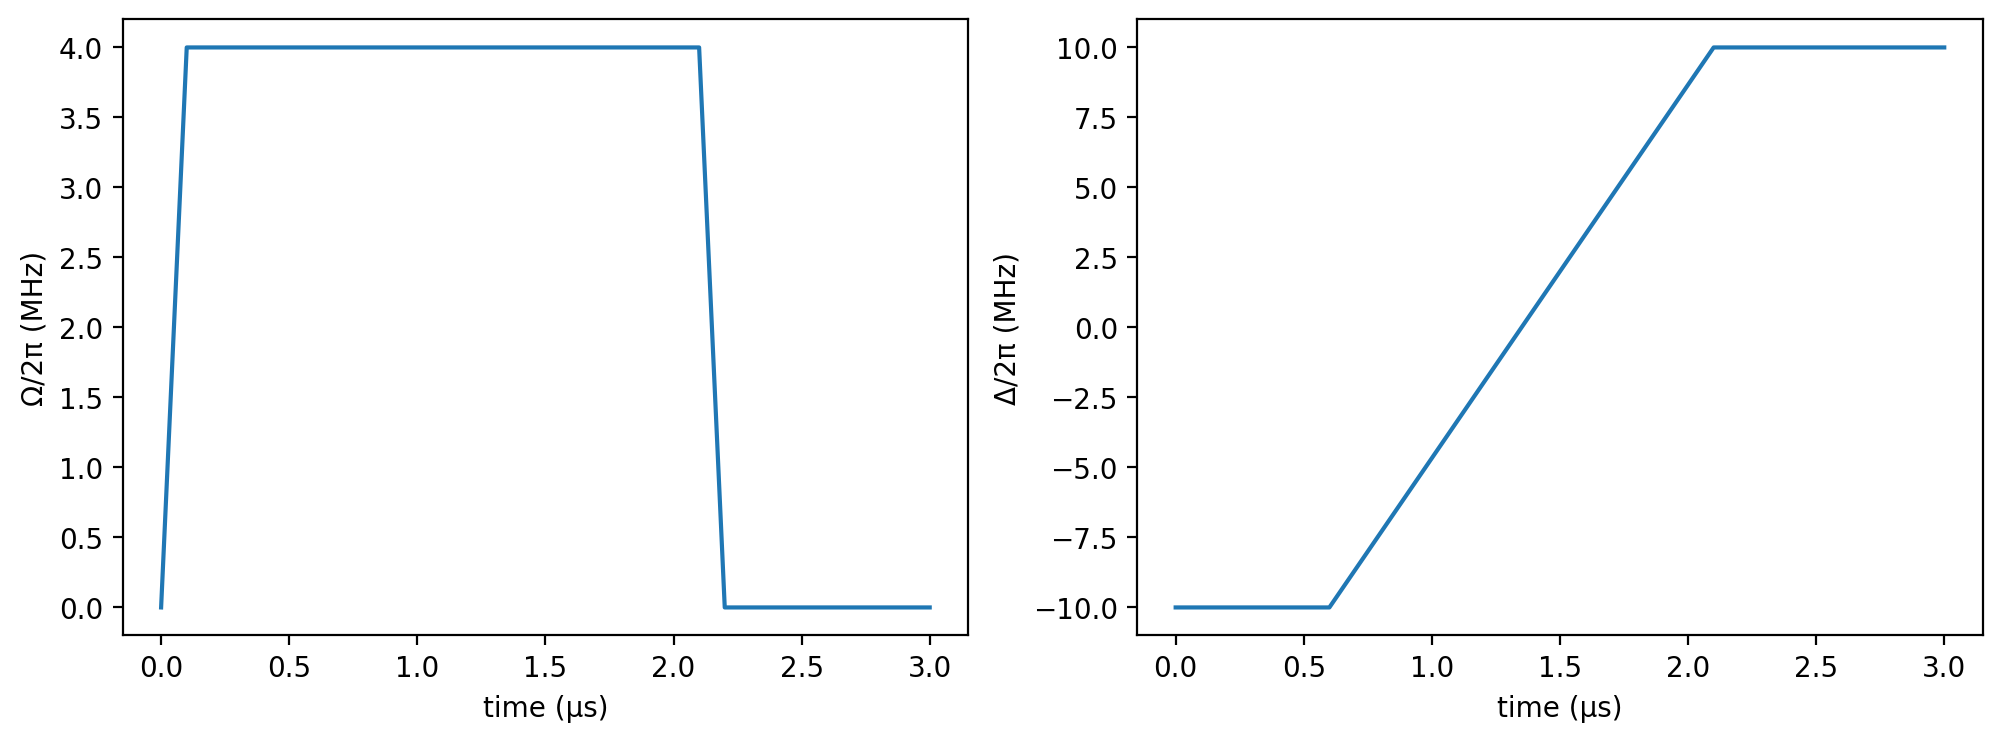

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

In [33]:
nsites = 5
atoms = generate_sites(ChainLattice(), nsites, scale = 5.72)

h01 = rydberg_h(atoms; Δ, Ω)

nqubits: 5
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


In [34]:
reg = zero_state(5);
prob = SchrodingerProblem(reg, total_time, h01);
integrator = init(prob, Vern8());

In [35]:
densities = []
for _ in TimeChoiceIterator(integrator, 0.0:1e-3:total_time)
    push!(densities, rydberg_density(reg))
end
D = hcat(densities...);

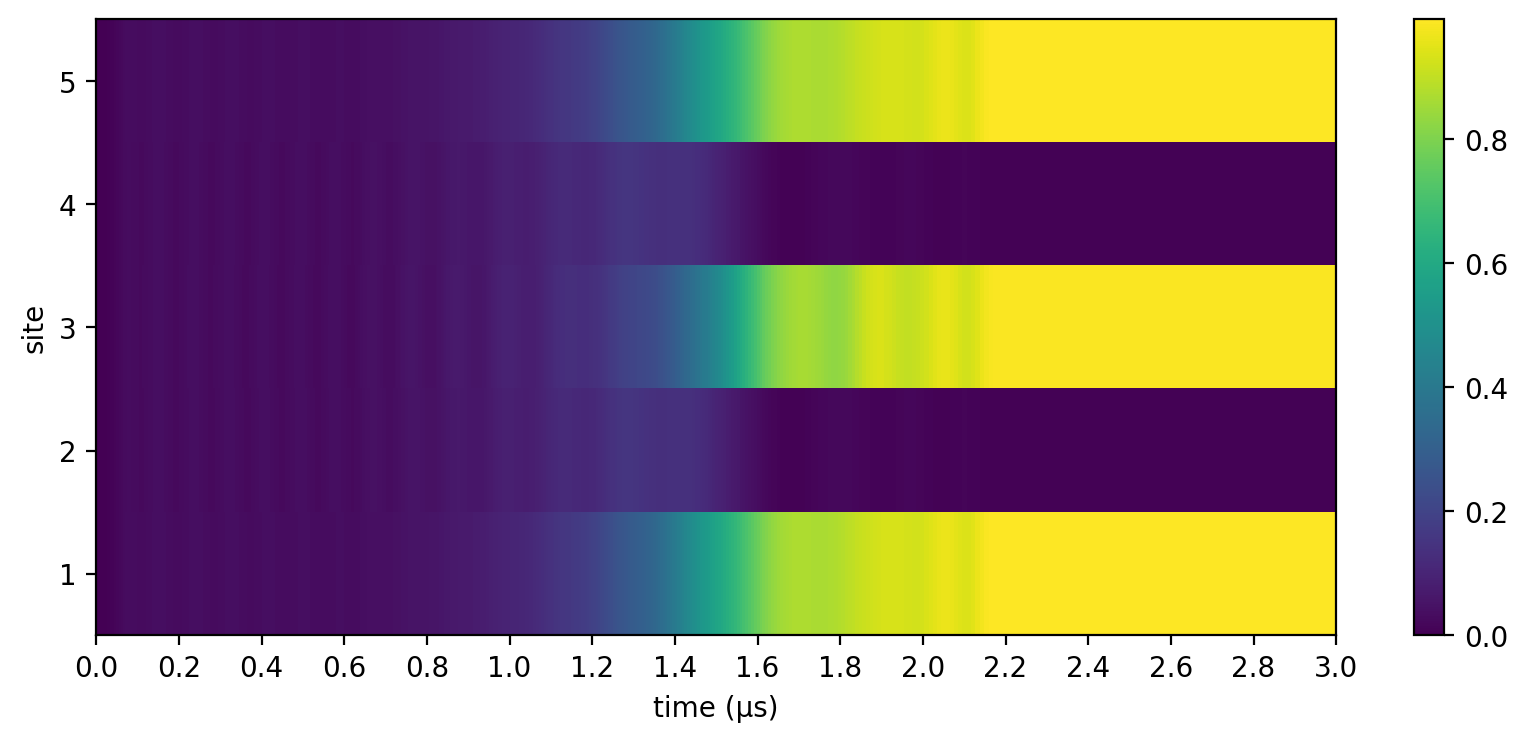

In [22]:
fig, ax = plt.subplots(figsize = (10,4))
shw = ax.imshow(real(D), interpolation="nearest", aspect="auto", extent=[0,total_time,0.5,nsites+0.5])
ax.set_xlabel("time (μs)")
ax.set_ylabel("site")
ax.set_xticks(0:0.2:total_time)
ax.set_yticks(1:nsites)
bar = fig.colorbar(shw)
fig

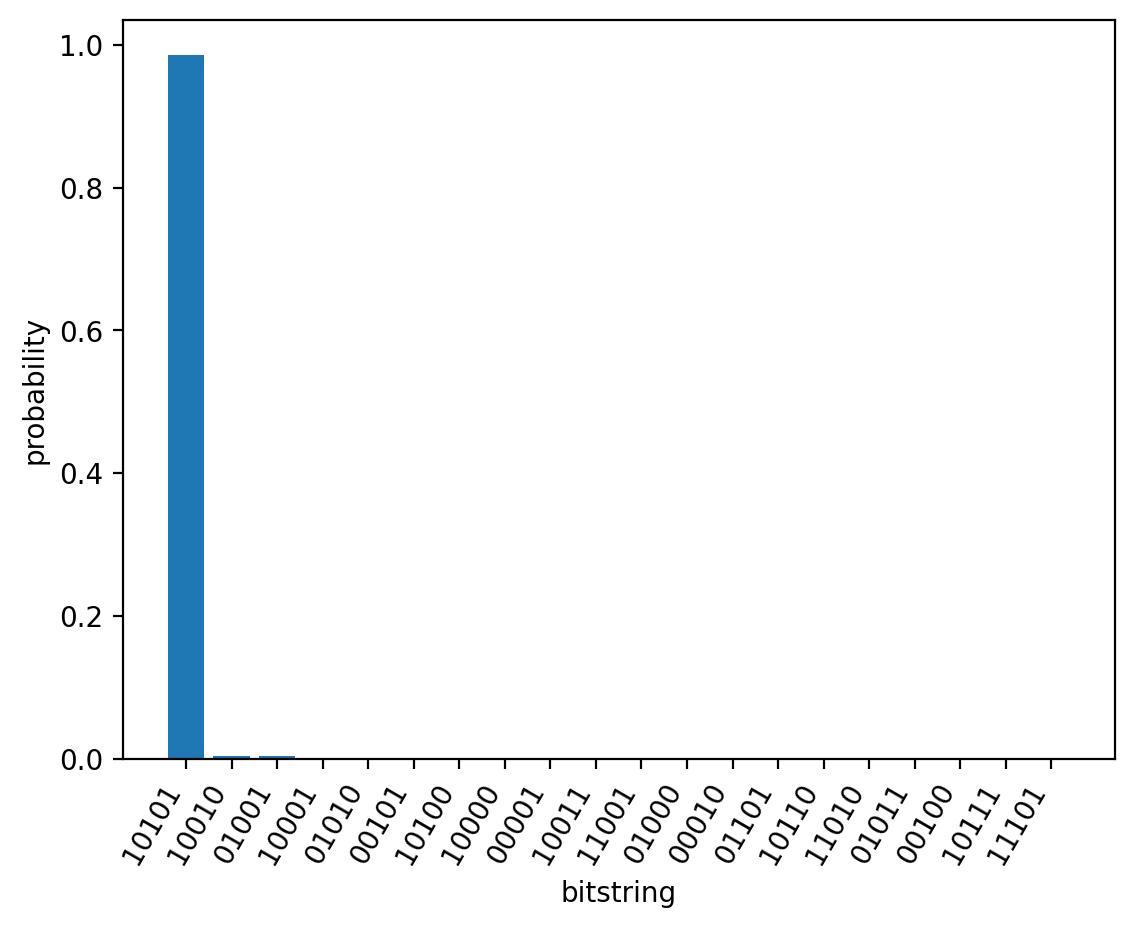

In [36]:
bitstring_hist(reg; nlargest = 20)